<a href="https://colab.research.google.com/github/akashmat/CMPE-257-Group-11/blob/main/Report_Akash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, preprocessing, feature_extraction, linear_model

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Finding Groups in the Train Data
It is observed that  train data contains mutations. We can see from the training set to see how mutations affects the target. This is a required step because test data is all mutations.

In [3]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
train_df.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


#### Find Mutations, Insertions, Deletions
Below we find training set mutations, insertions, deletions. For each observed protein sequence length, we compare all rows with ± DEL_THRESH sequence length. 

In [ ]:
train_df['x'] = train_df.protein_sequence.str.len()
vc = train_df.x.value_counts()

In [ ]:
len(vc)

1965

There are 1965 unique lengths protein sequence in the training set.

In [ ]:
# Custom Levenshtein Matrix function from stackoverflow as such a package is not available in python.

from Levenshtein import distance

def get_distance_matrix(str_list):
    matrix = np.zeros(shape=(len(str_list), len(str_list)))

    for i in range(0, len(str_list)):
        for j in range(i+1, len(str_list)):
            matrix[i][j] = distance(str_list[i], str_list[j]) 
    for i in range(0, len(str_list)):
        for j in range(0, len(str_list)):
            if i == j:
                matrix[i][j] = 0 
            elif i > j:
                matrix[i][j] = matrix[j][i]

    return matrix

In [ ]:
train_df['group'] = -1
grp_idx = 0

MUT_THRESH = 10
DEL_THRESH = 3

for k in range(len(vc)):
    c = vc.index[k]
    
    # Getting subset of training data withing the threshold distance
    tmp = train_df.loc[(train_df.x>=c-DEL_THRESH) & 
                       (train_df.x<=c+DEL_THRESH) & 
                       (train_df.group==-1)]
    if len(tmp)<=1: break
    
    # Levenstein Distance
    x = get_distance_matrix(tmp.protein_sequence.tolist())
    
    # Finding the number of mutations
    mutations = []
    for m in range(1, MUT_THRESH + 1):
        mutations.append( len( np.unique( np.where( x==m )[0] ) ) )
        
    # finding rows with mutations within the threshold
    mut_rows = np.unique( np.where( (x>0)&(x<=MUT_THRESH) )[0] )
    seen = []
    for j in mut_rows:
        if j in seen: continue
        i = np.where( np.array(x[j,])<=MUT_THRESH )[0]
        seen += list(i)
        idx = tmp.iloc[i].index
        train_df.loc[idx,'group'] = grp_idx
        grp_idx += 1

Saving the new dataset with a group column.

In [ ]:
train_df = train_df.drop('x',axis=1)
train_df.to_csv('train_with_groups.csv',index=False)
train_df.head()

,seq_id,protein_sequence,pH,data_source,tm,group
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,-1
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,-1
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,-1
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,-1
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,-1


<AxesSubplot:ylabel='Density'>

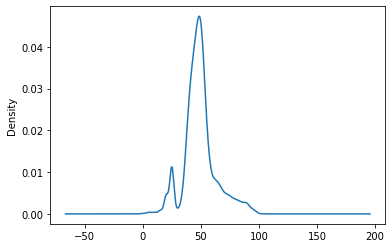

In [ ]:
train_df['tm'].plot(kind = 'density')

The target seems to be kind of normally distributed with values between 45-50 as the most frequently occuring one

In [ ]:
print(f"Minimum value of target : {train_df.tm.min()}")
print(f"Maximum value of target : {train_df.tm.max()}")
print(f"Median value of target : {train_df.tm.median()}")
print(f"Minimum value of pH : {train_df.pH.min()}")
print(f"Maximum value of pH : {train_df.pH.max()}")
print(f"Median value of pH : {train_df.pH.median()}")

Minimum value of target : -1.0
Maximum value of target : 130.0
Median value of target : 48.0
Minimum value of pH : 1.99
Maximum value of pH : 64.9
Median value of pH : 7.0


#### Group K-Fold
It is very important to keep track of grouping within the dataset in case of certain machine learning problems, and Group K-Fold can be of great help in such situations. Properties of Group K-Fold (from scikit-learn):
- K-fold iterator variant with non-overlapping groups.
- The same group will not appear in two different folds (the number of distinct groups has to be at least equal to the number of folds).
- The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

The grps parameter is simply a list representing which group each sample belongs to. We pass this list of groups as a parameter to the split() function along with the dataset.

#### Feature Extraction and Linear Regression
Using Bigram count vectorizer to extract features from our protein sequence so that they can be used for regression.

In [4]:
# Group numbering starts from -1 being spread across groups.
train_df = pd.read_csv('train_with_groups.csv')

#Collecting rows with rows previously marked '-1', i.e., without a group.
neg_row = train_df.loc[train_df.group==-1].shape[0]
#Finding the maximum number of grouping.
num_groups = train_df.group.max()
# Spreading the ungrouped across the present groups
train_df.loc[train_df.group==-1,'group'] = np.arange(neg_row) + num_groups + 1

In [5]:
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

SEED = 42
N_FOLDS = 5

X = train_df[['protein_sequence']]
y = train_df[['tm']]
groups = train_df.group

groupKFold = model_selection.GroupKFold(n_splits = N_FOLDS)
kfold = model_selection.GroupKFold(n_splits = 5)

In [6]:
def gen_features(train_fold, valid_fold):
    train_fold['text'] = train_fold['protein_sequence'].apply(lambda x: ' '.join(list(x)))
    valid_fold['text'] = valid_fold['protein_sequence'].apply(lambda x: ' '.join(list(x)))
    test_df['text'] = test_df['protein_sequence'].apply(lambda x: ' '.join(list(x)))
    corpus = train_fold['text'].values.tolist()
    
    # Convert a collection of text documents to a matrix of token counts.
    count_vect = feature_extraction.text.CountVectorizer(
                        token_pattern='[A-Z]', 
                        analyzer = 'char',
                        ngram_range=(1,2),
                        stop_words = None
                    )
    count_vect = count_vect.fit(corpus)
    X_train = count_vect.transform(train_fold['text'].values.tolist())
    y_train = train_fold['tm'].values
    X_valid = count_vect.transform(valid_fold['text'].values.tolist())
    y_valid = valid_fold['tm'].values
    X_test = count_vect.transform(test_df['text'].values.tolist())
    
    return X_train, y_train, X_valid, y_valid, X_test

In [7]:
test_preds = np.zeros((test_df.shape[0]))
folds_score = []

for fold, (trn_idx, val_idx) in enumerate(groupKFold.split(X, y, groups)):
    train_fold, valid_fold = train_df.iloc[trn_idx], train_df.iloc[val_idx] 
    
    X_train, y_train, X_valid, y_valid, X_test = gen_features(train_fold, valid_fold)
    
    linear_reg = linear_model.LinearRegression()
    linear_reg.fit(X_train ,y_train)
    y_valid_preds = linear_reg.predict(X_valid)
    
    corr_score = pd.concat([pd.DataFrame(valid_fold.tm.values , columns=['Actual']), 
                            pd.DataFrame(y_valid_preds, columns=['Predicted'])],axis=1).corr(method='spearman')['Actual']['Predicted']
    folds_score.append(corr_score)
    print(f"Correlation Score for fold {fold} is  {corr_score}")
    test_preds+= linear_reg.predict(X_test)
    
print(f"Mean {N_FOLDS} Folds Spearmann Correlation Score : {np.array(folds_score).mean()}")
test_preds = test_preds / N_FOLDS

Correlation Score for fold 0 is  0.18611224592022765
Correlation Score for fold 1 is  0.2744624843696969
Correlation Score for fold 2 is  0.17963823035298912
Correlation Score for fold 3 is  0.30363948679206837
Correlation Score for fold 4 is  0.19563587795699497
Mean 5 Folds Spearmann Correlation Score : 0.2278976650783954


### Rigde Regression

In [8]:
def gen_features_Tfidf(train_fold, valid_fold):
    train_fold['text'] = train_fold['protein_sequence'].apply(lambda x: ' '.join(list(x)))
    valid_fold['text'] = valid_fold['protein_sequence'].apply(lambda x: ' '.join(list(x)))
    test_df['text'] = test_df['protein_sequence'].apply(lambda x: ' '.join(list(x)))
    corpus = train_fold['text'].values.tolist()
    
    # Convert a collection of text documents to a matrix of token counts.
    count_vect = feature_extraction.text.TfidfVectorizer(
                    token_pattern='[A-Z]',
                    analyzer='char', 
                    ngram_range=(2,8), 
                    sublinear_tf=True, 
                    stop_words=None)
    
    count_vect = count_vect.fit(corpus)
    X_train = count_vect.transform(train_fold['text'].values.tolist())
    y_train = train_fold['tm'].values
    X_valid = count_vect.transform(valid_fold['text'].values.tolist())
    y_valid = valid_fold['tm'].values
    X_test = count_vect.transform(test_df['text'].values.tolist())
    
    return X_train, y_train, X_valid, y_valid, X_test

In [9]:
test_preds = np.zeros((test_df.shape[0]))
folds_score = []

for fold, (trn_idx, val_idx) in enumerate(groupKFold.split(X, y, groups)):
    train_fold, valid_fold = train_df.iloc[trn_idx], train_df.iloc[val_idx]
    
    X_train, y_train, X_valid, y_valid, X_test = gen_features_Tfidf(train_fold, valid_fold)
    
    linear_reg = linear_model.Ridge()
    linear_reg.fit(X_train, y_train)
    y_valid_preds = linear_reg.predict(X_valid)
    
    corr_score = pd.concat([pd.DataFrame(valid_fold.tm.values , columns=['Actual']), 
                            pd.DataFrame(y_valid_preds, columns=['Predicted'])],axis=1).corr(method='spearman')['Actual']['Predicted']
    folds_score.append(corr_score)
    print(f"Correlation Score for fold {fold} is  {corr_score}")
    test_preds+= linear_reg.predict(X_test)
    
print(f"Mean {N_FOLDS} Folds Spearmann Correlation Score : {np.array(folds_score).mean()}")
test_preds = test_preds / N_FOLDS

Correlation Score for fold 0 is  0.2989258231313675
Correlation Score for fold 1 is  0.4212503714016043
Correlation Score for fold 2 is  0.30589194508850126
Correlation Score for fold 3 is  0.41897359261506756
Correlation Score for fold 4 is  0.33320010901473424
Mean 5 Folds Spearmann Correlation Score : 0.355648368250255


In [ ]:
test_preds

array([47.87710228, 47.67885797, 47.79396917, ..., 47.95038749,
       47.94696215, 47.73322398])

In [ ]:
# Code for submission
submission = pd.read_csv('./sample_submission.csv')
submission['tm'] = test_preds
submission.head()

,seq_id,tm
0,31390,47.877102
1,31391,47.678858
2,31392,47.793969
3,31393,47.886354
4,31394,47.890549


Unlike the distribution of tm from train file which was distributed well between 0-130 range approximately our tm here looks to be distributed only between 47 -49 approximately

May be this model is too simple for the task at hand and we are underfitting.

In [ ]:
ss.to_csv("sumbission.csv",index = False)